In [35]:
%pip install -q matplotlib scikit-learn seaborn textblob inflect pycountry spacy


Note: you may need to restart the kernel to use updated packages.


In [3]:

import pandas as pd
import numpy as np
import json
import os
import csv
import time
import re
import matplotlib.pyplot as plt
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import inflect
import pycountry 


In [157]:
testing_df2 = pd.read_csv(r'C:\Users\wingy\UTS\Crisistunity - Experiments - Results\Information Type\combined_information_type.csv')


In [158]:
#Parse text functions
#################################################  
# Extracting the Crisis Type label from the text#
#################################################  
def parse_label_crisistype(text):
  colon_index = text.lower().find('"crisis": ')
  if colon_index != -1:
    substring = text[ colon_index +len('"Crisis": '):]
    # Find the index of the closing double quote or closing quote
    if substring.startswith('"'):
      end_index = substring.find('"',1)
      if end_index != -1:
        return substring[1:end_index]
      else:
        return "missing 2nd apostrophe"
    else:
      end_index = substring.find("\n")
      if end_index != -1:
        return substring[:end_index]
      else:
        return "missing '\n'"
  else:
    return "No 'Crisis' key in data"

#######################################################    
# Extracting the Information Type label from the text #
#######################################################   
InfoTypeLabels =  [ "Caution and advice for residents", "Affected residents", "Infrastructure and utilities damage", "Donations or volunteering", "expressing Sympathy and support for affected", "other useful information", "Not applicable"]

def parse_label_infotype(text):
    # remoe period and hashtag
    text = text.replace(".", "")
    text = text.replace("#", "")
    substring = None
    colon_index = text.lower().find("label:")
    if colon_index != -1:
        second_colon_index = text.find(":", colon_index + 6)
        if second_colon_index != -1:
            substring = text[colon_index + 6:second_colon_index]
            for label in InfoTypeLabels:
                if label.lower() in substring.lower():
                    return label 
    for label in InfoTypeLabels:
        if label.lower() in text.lower():
            return label
    value = re.findall(r'"(.*?)"', text)
    if value:
        return value[0]
    if substring:
                return substring

    return "Error"


  ##############################################                                            
  # Extracting the Country label from the text #
  ##############################################                                          
def parse_label_country(text):
    # Remove the word "ISO" from the string
    text = text.replace("ISO", "")

# Loop through all countries in pycountry
    for country in pycountry.countries:
        # Check if the country name is in the string
        if country.name.lower() in text.lower():
            return country.name
            break
     
# Loop through all countries in alpha 3 pycountry
    for country in pycountry.countries:
        if country.alpha_3 in text:
            return country.name
            break
    
# Loop through all countries in alpha 2 pycountry
    for country in pycountry.countries:
        if country.alpha_2 in text:
            return country.name
            break
    if 'UK' in text or 'Scotland' in text:
        return "United Kingdom"
    if 'Syria' in text:
        return "Syrian Arab Republic"
    if 'Russia' in text:
        return "Russian Federation"
    if 'Venezuela' in text or 'VZL' in text or 'VZ' in text:
        return "Venezuela, Bolivarian Republic of" 
    if 'SP' in text or 'España' in text:
        return "Spain"
    return 'Country Not Found' 


In [118]:
parse_label_infotype('  Label: Not applicable This tweet does not contain any information related to a crisis. It is a random law in Texas about throwing fruit peels on the street, and does not provide any information that would be useful in a crisis situation. Therefore, it does not apply to any of the labels provided.')

'Not applicable'

In [181]:

# Turn plural into singular of the parsed labels using inflect and change to sentence case
def singular_label(df, parsed_column):
    # Create an instance of the inflect engine
    engine = inflect.engine()

    
    # Convert a plural word to a singular word
    df[parsed_column] = df[parsed_column].apply(
        lambda x: engine.singular_noun(x) if engine.singular_noun(x) else x)

    # Change to sentence case
    df[parsed_column] = df[parsed_column].str.capitalize()


# Rename parsed labels so they match original labels in the dataset
def rename_label(df, parsed_column, label_column):
    # Define a dictionary to map old labels to new labels
    label_map = {
        'Wildfires': 'Wildfire',
        'Bushfires': 'Wildfire',
        'Bushfire': 'Wildfire',
        'Na': 'Not labeled',
        '[Na]': 'Not labeled',
        'fire': 'Wildfire',
        
        "Not applicable": 'Not labeled', "Other useful information": 'Other Useful Information', "Caution and advice for residents": 'Caution and advice', "Affected resident": 'Affected individuals', "Infrastructure and utilities damage": 'Infrastructure and utilities', "Donations and volunteering": 'Donations and volunteering', "Donations or volunteering": 'Donations and volunteering', "Expressing sympathy and support for affected": 'Sympathy and support', "Warnings and advice for residents.": 'Caution and advice',
        
        # 'Warnings and issue': 'Caution and advice', 'Warnings and advisory': 'Caution and advice', 'Warnings/issue': 'Caution and advice', 'Warnings and advice': 'Caution and advice', 'Warnings issues or lifted': 'Caution and advice', 'Warnings and alert': 'Caution and advice', 'Warnings and issues.': 'Caution and advice', 'Warnings and tip': 'Caution and advice', 'Warnings and advice for residents': 'Caution and advice', 'Warnings and update': 'Caution and advice', 'Warnings, issues or lifted': 'Caution and advice', 'Warnings and advice.': 'Caution and advice', 'Warnings and lift': 'Caution and advice', 'Warnings issue': 'Caution and advice', 'Warnings and information': 'Caution and advice'
    }
    # Define a dictionary to map old labels to new labels
    label_map_actual = {
        'Philipinnes': 'Philippines',
        'Phillipines': 'Philippines',
        'UK': 'United Kingdom',
        'Venezuela': 'Venezuela, Bolivarian Republic of',
        'Russia': 'Russian Federation',
        'US': 'United States',
    }
    # Rename the parsed_column 
    df[parsed_column] = df[parsed_column].replace(label_map)
    
    # Rename parsed_column value based on keywords for the Information Type
    keywords_dict = {'warning': 'Caution and advice', 'caution': 'Caution and advice','notapplicable': 'Not labeled','otherusefulinformation': 'Other Useful Information',}
    for keyword in keywords_dict.keys():
        df[parsed_column] = df[parsed_column].apply(lambda x: keywords_dict[keyword] if keyword.lower() in x.lower() else x)

    # Relabel the "Not labeled" Information Type entries as "Not labeled" for the Crisis Type
    df.loc[df["InformationType"] == "Not labeled", label_column] = "Not labeled"

    # Rename the label_column using the label_map dictionary
    df[label_column] = df[label_column].replace(label_map_actual)


# # Rename predicted entries that are not in the top 8 as not labeled
# #Count the values in the "Label" column
# label_counts = testing_df2['parsed_pred_crisis_type_13'].value_counts()

# # Define the threshold for the top labels
# threshold = 8

# # Get the labels that meet the threshold
# top_labels = label_counts.index[:threshold]

# # Replace the labels that do not meet the threshold with "Not labeled"
# testing_df2['parsed_pred_crisis_type_13'] = testing_df2['parsed_pred_crisis_type_13'].replace(to_replace={value: 'Not labeled' for value in testing_df2['parsed_pred_crisis_type_13'].unique() if value not in top_labels})


In [182]:
# Rename predicted entries that are not in the top 8 as not labeled
def top_labels(df, parsed_column):
    #Count the values in the "Label" column
    label_counts = df[parsed_column].value_counts()

    # Define the threshold for the top labels
    threshold = 9

    # Get the labels that meet the threshold
    top_labels = label_counts.index[:threshold]

    # Replace the labels that do not meet the threshold with "Other"
    df[parsed_column] = df[parsed_column].replace(to_replace={value: 'Other' for value in df[parsed_column].unique() if value not in top_labels})
 

In [183]:
#Apply Parse function for information type and get answers in sentence case
testing_df2['parsed_pred_infotype'] = testing_df2['Pred_InformationType_v9v3'].apply(parse_label_infotype)

In [184]:
singular_label(testing_df2,'parsed_pred_infotype')
rename_label(testing_df2,'parsed_pred_infotype', 'InformationType')


In [128]:
infotype_df=testing_df2[["TweetText","InformationType","Pred_InformationType_v9v3","parsed_pred_infotype"]]

# save df as csv testing_df2
testing_df2.to_csv(r"C:\Users\wingy\OneDrive\DATA SCIENCE\ilab2\Parsed Resuts\infotype2.csv", index = None, header=True)


In [185]:
top_labels(testing_df2, 'parsed_pred_infotype')


In [186]:
#Count the values in the "Label" column
label_counts = testing_df2['parsed_pred_infotype'].value_counts()
label_counts
# label_counts.to_csv(r"C:\Users\wingy\OneDrive\DATA SCIENCE\ilab2\Parsed Resuts\infotype_labelcount.csv", index = True, header=True)


parsed_pred_infotype
Affected individuals            8520
Other Useful Information        5341
Not labeled                     4895
Sympathy and support            2706
Caution and advice              1969
Donations and volunteering      1307
Infrastructure and utilities    1128
Other                            102
Error                             10
Useful information                 9
Name: count, dtype: int64

In [ ]:
# #Apply Parse function and get answers in sentence case
# testing_df2['parsed_pred_country'] = testing_df2['country_pred'].apply(parse_label_country)
# country_df=testing_df2[["TweetText","country","InformationType","country_pred","parsed_pred_country"]]
# # save df as csv testing_df2
# testing_df2.to_csv(r'C:\Users\wingy\UTS\Crisistunity - Experiments - Results\Country\result_df_country.csv', index = None, header=True)
#Count the values in the "Label" column
# label_counts = testing_df2['parsed_pred_country'].value_counts()
# print(label_counts)

In [ ]:
# Apply singular and sentence case to parsed labels
# singular_label(testing_df2, 'parsed_pred_crisis_type_13')
# Rename parsed labels so they match original labels in the dataset
# rename_label(testing_df2, 'parsed_pred_crisis_type_13', 'type')

In [295]:
# show the first 20 rows of the dataframe with the columns "TweetText","country","InformationType","country_pred","parsed_pred_country"
# country_df=testing_df2[["TweetText","country","InformationType","country_pred","parsed_pred_country"]].head(-25)



In [ ]:
# show the first 20 rows of the dataframe with the columns "TweetText","type","InformationType","pred_crisis_type_13","parsed_pred_crisis_type_13"
# testing_df2[["TweetText","type","InformationType","pred_crisis_type_13","parsed_pred_crisis_type_13"]].head(20)



In [ ]:
# save df as csv testing_df2
testing_df2.to_csv(r'C:\Users\wingy\UTS\Crisistunity - Experiments - Results\Country\result_df_country_e2_parsed2.csv', index = None, header=True)


In [187]:
# Create a confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

def plt_confusion_matrix ( actual_values, predicted_values):
  #Create the unique labels
  labels = unique_labels(actual_values, predicted_values)
  indices = np.where((labels == 'Not labeled') | (labels == 'Other') | (labels == 'Error'))
  labels = np.delete(labels, indices)
  labels = np.append(labels, [ 'Not labeled', 'Other', 'Error'])
  #compute the confusion matrix.
  cm = confusion_matrix(actual_values, predicted_values,labels=labels)
 
  print(cm)



  #Create a mask that selects the diagonal elements
  mask = np.eye(len(labels), dtype=bool)

  # Create a color map with blue off-diagonal elements and green diagonal elements
  cmap = sns.diverging_palette(220, 20, as_cmap=True)
  cmap.set_bad("green")

  #Plot the confusion matrix.
  fig, ax = plt.subplots(figsize=(10, 8))
  sns.heatmap(cm,
              annot=True,
              fmt='g',
              xticklabels=labels,
              yticklabels=labels,
              cbar=False,
              annot_kws={"fontsize":7})
  sns.heatmap(cm,
              # annot=False,
              # fmt='g',
              xticklabels=labels,
              yticklabels=labels,
              mask=mask,
              cmap=cmap, cbar=False, square=True, linewidths=1, linecolor='white' )

  plt.ylabel('Actual',fontsize=13)
  plt.xlabel('Prediction',fontsize=13)
  plt.title('Confusion Matrix',fontsize=17)
  plt.show()
  plt.clf()


  # Calculate accuracy
  accuracy = accuracy_score(actual_values, predicted_values)

  # Calculate precision
  precision = precision_score(actual_values, predicted_values, average='weighted')

  # Calculate recall
  recall = recall_score(actual_values, predicted_values, average='weighted')

  # Calculate F1-score
  f1 = f1_score(actual_values, predicted_values, average='weighted')

  
# Number of rows in dataframe

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-score: {f1}')
  print('Unique Predict Labels: ',list(np.unique(predicted_values)))
  print('Unique Actual Labels: ',list(np.unique(actual_values)))
  print('Number of rows: ',len(testing_df2.index))
  print(predicted_values.value_counts())

[[3725  201   18   86  308   87    0  271   17    0]
 [ 823  568   21  127  463   22    2  172   26    0]
 [ 373   35 1179   40  502   83    4  107   13    0]
 [ 635  104   12  324  318   13    0  134    4    1]
 [2062  672   21  439 2328  117    3 1505   21    2]
 [ 366  179   32    4  486 2224    0  900    6    2]
 [   0    0    0    0    0    0    0    0    0    0]
 [ 536  210   24  108  936  160    0 1806   15    5]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


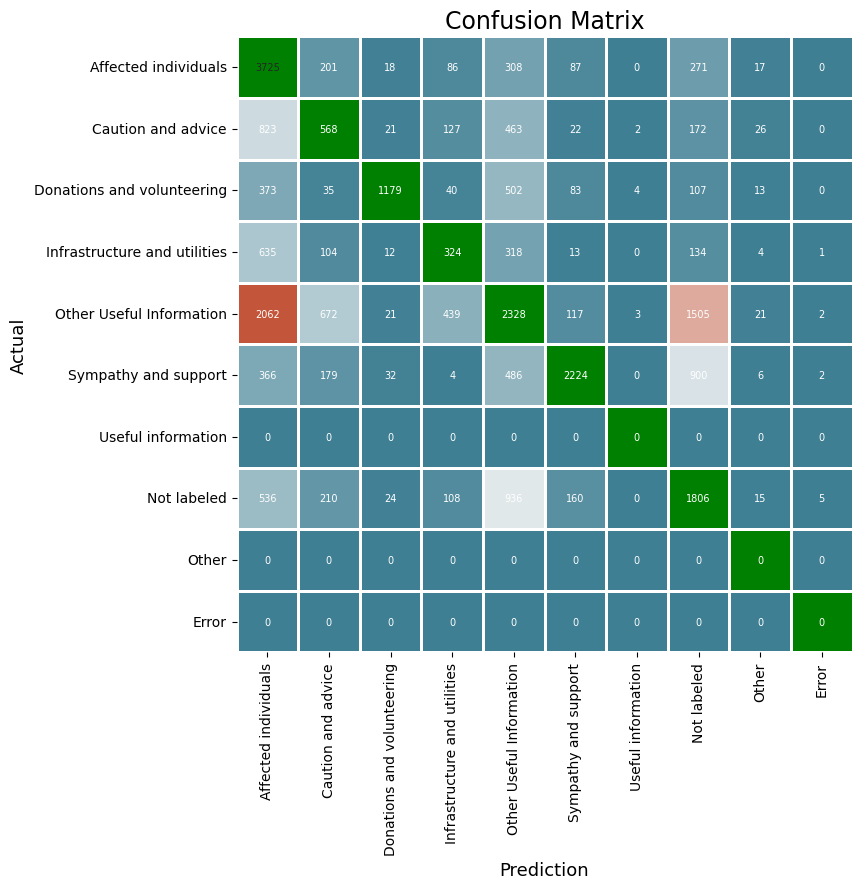

c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.46769538615461576
Precision: 0.5091543632219417
Recall: 0.46769538615461576
F1-score: 0.46539551243909744
Unique Predict Labels:  ['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Error', 'Infrastructure and utilities', 'Not labeled', 'Other', 'Other Useful Information', 'Sympathy and support', 'Useful information']
Unique Actual Labels:  ['Affected individuals', 'Caution and advice', 'Donations and volunteering', 'Infrastructure and utilities', 'Not labeled', 'Other Useful Information', 'Sympathy and support']
Number of rows:  25987
parsed_pred_infotype
Affected individuals            8520
Other Useful Information        5341
Not labeled                     4895
Sympathy and support            2706
Caution and advice              1969
Donations and volunteering      1307
Infrastructure and utilities    1128
Other                            102
Error                             10
Useful information                 9
Name: count, dtype: int64


<Figure size 640x480 with 0 Axes>

In [188]:

# CM for Information Type 

#remove NULL entries from the dataframe
testing_df2 = testing_df2[testing_df2['InformationType'].notnull()]
#Merge not labeled and not applicable from the dataframe
testing_df2['InformationType'] = testing_df2['InformationType'].replace(to_replace={'Not applicable': 'Not labeled'})

plt_confusion_matrix(testing_df2['InformationType'],testing_df2['parsed_pred_infotype'])

In [ ]:
# # Create a confusion matrix
# import numpy as np
# from sklearn.metrics import confusion_matrix
# from sklearn.utils.multiclass import unique_labels
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plt_confusion_matrix ( actual_values, predicted_values):
#   #compute the confusion matrix.
#   cm = confusion_matrix(actual_values, predicted_values)
#   cm = cm[np.any(cm, axis=1)]
#   print(cm)


#   #Create the unique labels
#   # labels = unique_labels(actual_values, predicted_values)
#   ylabel=np.unique(actual_values)
#   xlabel=np.unique(predicted_values) 

#   # Create a mask that selects the diagonal elements
#   # mask = np.eye(len(labels), dtype=bool)

#   # Create a color map with blue off-diagonal elements and green diagonal elements
#   cmap = sns.diverging_palette(220, 20, as_cmap=True)
#   cmap.set_bad("green")


#   #Plot the confusion matrix.
#   fig = plt.figure()
#   sns.heatmap(cm,
#               annot=True,
#               fmt='g',
#               xticklabels=xlabel,
#               yticklabels=ylabel,
#               cbar=False)
#   sns.heatmap(cm,
#               # annot=False,
#               # fmt='g',
#               xticklabels=xlabel,
#               yticklabels=ylabel,
#               mask=mask,
#               cmap=cmap, cbar=False, square=True, linewidths=1, linecolor='white' )

#   plt.ylabel('Actual',fontsize=13)
#   plt.xlabel('Prediction',fontsize=13)
#   plt.title('Confusion Matrix',fontsize=17)
#   plt.show()
#   plt.clf()


#   # Calculate accuracy
#   accuracy = accuracy_score(actual_values, predicted_values)

#   # Calculate precision
#   precision = precision_score(actual_values, predicted_values, average='weighted')

#   # Calculate recall
#   recall = recall_score(actual_values, predicted_values, average='weighted')

#   # Calculate F1-score
#   f1 = f1_score(actual_values, predicted_values, average='weighted')

  
# # Number of rows in dataframe

#   print(f'Accuracy: {accuracy}')
#   print(f'Precision: {precision}')
#   print(f'Recall: {recall}')
#   print(f'F1-score: {f1}')
#   print('Unique Predict Labels: ',list(np.unique(predicted_values)))
#   print('Unique Actual Labels: ',list(np.unique(actual_values)))
#   print('Number of rows: ',len(testing_df2.index))
#   print(predicted_values.value_counts())

In [315]:
# # Create a confusion matrix for country
# import numpy as np
# from sklearn.metrics import confusion_matrix
# from sklearn.utils.multiclass import unique_labels
# import seaborn as sns
# import matplotlib.pyplot as plt

# def plt_confusion_matrix ( actual_values, predicted_values):
#   #Create the unique labels
#   labels = unique_labels(actual_values, predicted_values)
#   indices = np.where((labels == 'Not labeled') | (labels == 'Country Not Found') | (labels == 'Other'))
#   labels = np.delete(labels, indices)
#   labels = np.append(labels, ['Country Not Found', 'Not labeled', 'Other'])
  
#   #compute the confusion matrix.
#   cm = confusion_matrix(actual_values, predicted_values,labels=labels)
 
#   print(cm)



#   # #Create a mask that selects the diagonal elements
#   mask = np.eye(len(labels), dtype=bool)

#   # Create a color map with blue off-diagonal elements and green diagonal elements
#   cmap = sns.diverging_palette(220, 20, as_cmap=True)
#   cmap.set_bad("green")
  
#   #Plot the confusion matrix.
#   fig, ax = plt.subplots(figsize=(10, 8))
#   sns.heatmap(cm,
#               annot=True,
#               fmt='g',
#               xticklabels=labels,
#               yticklabels=labels,
#               cbar=False,
#               annot_kws={"fontsize":7})
#   sns.heatmap(cm,
#               # annot=False,
#               # fmt='g',
#               xticklabels=labels,
#               yticklabels=labels,
#               mask=mask,
#               cmap=cmap, cbar=False, square=True, linewidths=1, linecolor='white')

#   plt.ylabel('Actual',fontsize=13)
#   plt.xlabel('Prediction',fontsize=13)
#   plt.title('Confusion Matrix',fontsize=17)
#   plt.show()
#   plt.clf()


#   # Calculate accuracy
#   accuracy = accuracy_score(actual_values, predicted_values)

#   # Calculate precision
#   precision = precision_score(actual_values, predicted_values, average='weighted')

#   # Calculate recall
#   recall = recall_score(actual_values, predicted_values, average='weighted')

#   # Calculate F1-score
#   f1 = f1_score(actual_values, predicted_values, average='weighted')

  
# # Number of rows in dataframe

#   print(f'Accuracy: {accuracy}')
#   print(f'Precision: {precision}')
#   print(f'Recall: {recall}')
#   print(f'F1-score: {f1}')
#   print('Unique Predict Labels: ',list(np.unique(predicted_values)))
#   print('Unique Actual Labels: ',list(np.unique(actual_values)))
#   print('Number of rows: ',len(testing_df2.index))
#   print(predicted_values.value_counts())

c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


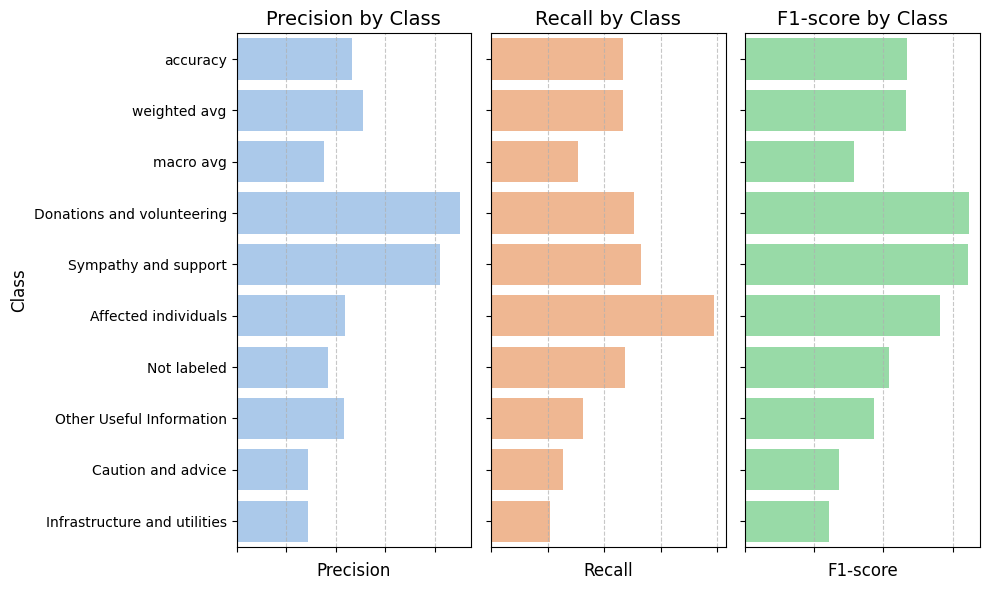

In [222]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Generate the classification report
report = classification_report(testing_df2['InformationType'], testing_df2['parsed_pred_infotype'], output_dict=True)

# Convert the report to a DataFrame
df = pd.DataFrame(report).transpose()

# Exclude the "Error", "Other", and "Useful information" labels from the DataFrame
df = df.drop(['Error', 'Other', 'Useful information'])

# Sort the DataFrame by F1-score, but keep the accuracy macro avg and weighted avg at the bottom
df = df.sort_values(by=['f1-score'], ascending=False)
df = pd.concat([df[df.index.isin(['accuracy', 'macro avg', 'weighted avg'])], df[~df.index.isin(['accuracy', 'macro avg', 'weighted avg'])]])

# Set the color palette
colors = sns.color_palette('pastel')

fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(10, 6))

# Create the precision plot
ax = sns.barplot(x=df['precision'], y=df.index, color=colors[0], ax=axes[0])
ax.set_title('Precision by Class', fontsize=14)
ax.set_xlabel('Precision', fontsize=12)
ax.set_ylabel('Class', fontsize=12)
ax.set(xticklabels=[])  # remove the tick labels
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Create the recall plot
ax = sns.barplot(x=df['recall'], y=df.index, color=colors[1], ax=axes[1])
ax.set_title('Recall by Class', fontsize=14)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.set(xticklabels=[])  # remove the tick labels
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Create the F1-score plot
ax = sns.barplot(x=df['f1-score'], y=df.index, color=colors[2], ax=axes[2])
ax.set_title('F1-score by Class', fontsize=14)
ax.set_xlabel('F1-score', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.set(xticklabels=[])  # remove the tick labels
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [224]:
df


,precision,recall,f1-score,support
accuracy,0.467695,0.467695,0.467695,0.467695
weighted avg,0.509154,0.467695,0.465396,25987.000000
macro avg,0.354168,0.308978,0.315534,25987.000000
Donations and volunteering,0.902066,0.504709,0.647269,2336.000000
Sympathy and support,0.821877,0.529650,0.644171,4199.000000
Affected individuals,0.437207,0.790367,0.562986,4713.000000
Not labeled,0.368948,0.475263,0.415411,3800.000000
Other Useful Information,0.435873,0.324686,0.372153,7170.000000
Caution and advice,0.288471,0.255396,0.270928,2224.000000
Infrastructure and utilities,0.287234,0.209709,0.242424,1545.000000


[[1101    0    1    0    0    0    0    0    0    0    0    0    0    1
     0    0    0    0  657    0    7]
 [   0  813    0    3    0    0    0    0    0    0    0    0    0    0
     0    2    2    0   25    0   44]
 [   0    0  837    0    0    0    0    0    0    0    0    0    0    0
     0    0    1    0   71    0    8]
 [  63    0    1 1562    0    0    0    0    0    0    0    0    0    0
     1    0    4    0  166    0    5]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   2    0    0    0   35    3  655    1    1    0   12    0    0    0
     0    0    4    0  131    0   20]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   0    0    0    0   19    0    1    0  719    0   79    0    0    0
     0    0    1    3   76    0   21]
 [   0    

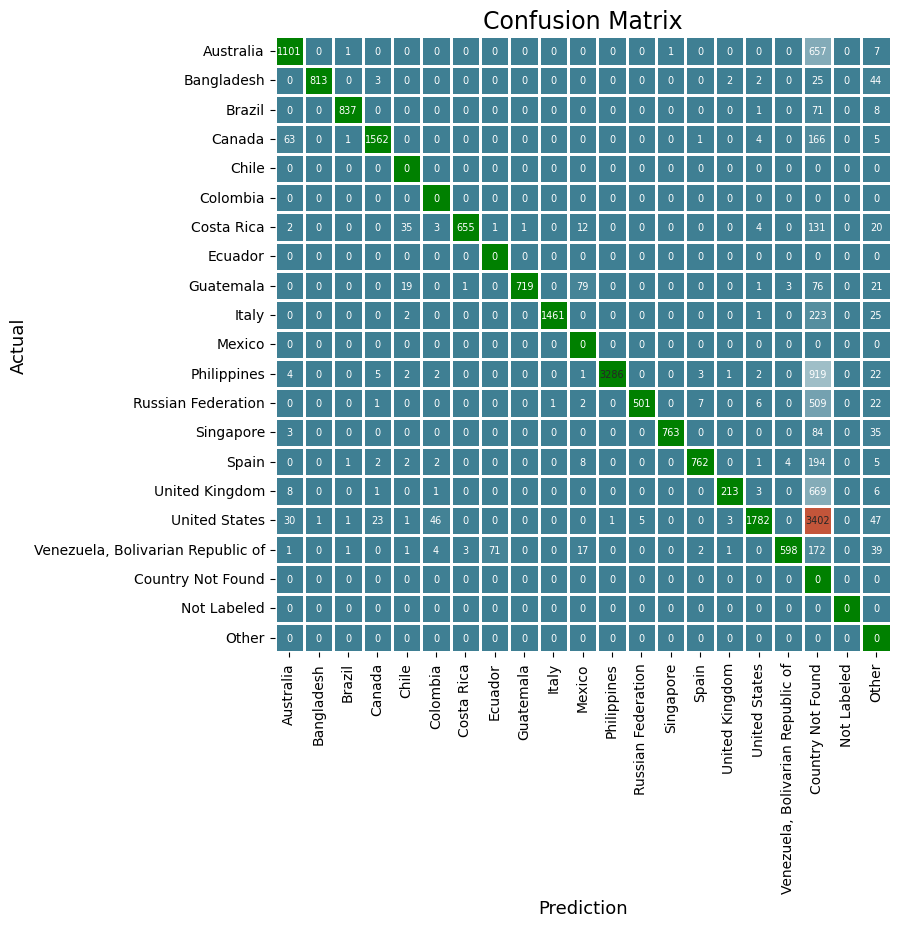

Accuracy: 0.6492559844727195
Precision: 0.9845621359268543
Recall: 0.6492559844727195
F1-score: 0.7584358069428289
Unique Predict Labels:  ['Australia', 'Bangladesh', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Country Not Found', 'Ecuador', 'Guatemala', 'Italy', 'Mexico', 'Other', 'Philippines', 'Russian Federation', 'Singapore', 'Spain', 'United Kingdom', 'United States', 'Venezuela, Bolivarian Republic of']
Unique Actual Labels:  ['Australia', 'Bangladesh', 'Brazil', 'Canada', 'Costa Rica', 'Guatemala', 'Italy', 'Philippines', 'Russian Federation', 'Singapore', 'Spain', 'United Kingdom', 'United States', 'Venezuela, Bolivarian Republic of']
Number of rows:  23185
parsed_pred_country
Country Not Found                    7298
Philippines                          3287
United States                        1807
Canada                               1597
Italy                                1462
Australia                            1212
Brazil                                842

c:\Users\wingy\anaconda3\envs\python_310_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

In [316]:
# # CM for Country 

# #remove NULL entries from the dataframe
# testing_df2 = testing_df2[testing_df2['country'].notnull()]
# #remove Not labeled entries from the dataframe
# testing_df2 = testing_df2[testing_df2['country'] != 'Not labeled']
# plt_confusion_matrix(testing_df2['country'],testing_df2['parsed_pred_country'])

In [ ]:
import inflect

# Create an instance of the inflect engine
engine = inflect.engine()

# Convert a plural word to a singular word
singular_word = engine.singular_noun('Philippines Floods')

# Print the singular word
print(singular_word)

Philippines Flood
